# NPxZxD chemostat model

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:


In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra as phydra

In [3]:
from phydra.utility.xsimlabwrappers import phydra_setup

In [4]:
from phydra.processes.main import Grid0D, Boundary0D
from phydra.processes.components import Component, SizeComponent, Time, make_Component
from phydra.processes.environments import Chemostat
from phydra.processes.fluxes import (SizeAllo_LimitedGrowth_Monod, HollingTypeIII, SizeBasedKernelGrazing,
                                     make_flux, make_multigrazing)
from phydra.processes.forcingfluxes import (SizeAllo_LinearMortalityClosure, QuadraticMortalityClosure, N0_inflow, Outflow, make_FX_flux)
from phydra.processes.forcing import (ConstantN0, ConstantFlow)
from phydra.processes.gekkocontext import GekkoContext, GekkoSolve, InheritGekkoContext

In [5]:
from phydra.processes.forcing import NutrientForcing, MLDForcing

In [6]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.81.gb5243f6.dirty


In [7]:
model = xs.Model({
    'time':Time, 'grid':Grid0D, 'ibcs':Boundary0D, 
    
    'context':GekkoContext,
                  
    'N':make_Component('Nutrient','N', comp_type=Component), 
    'P':make_Component('Phytoplankton','P', comp_type=SizeComponent),
    'Z':make_Component('Zooplankton','Z', comp_type=SizeComponent), 
    
    'Env':Chemostat, 
    
    # Fluxes
    'P_Growth':make_flux(SizeAllo_LimitedGrowth_Monod, 'G'), 
     
    'LinMortality':make_FX_flux(SizeAllo_LinearMortalityClosure, 'L'),
    
    'Grazing':make_multigrazing(SizeBasedKernelGrazing, 'X'), 
    
    # Closure (i.e. output from system)
    'QuadMortality':make_FX_flux(QuadraticMortalityClosure, 'Z'),
    
    # ForcingFluxes
    'N0_influx':make_FX_flux(N0_inflow, 'W'),
    'Outflux':make_FX_flux(Outflow, 'O'),
    
    'N0':ConstantN0,
    'Flow':ConstantFlow,
    
    'solver':GekkoSolve
})

model

<xsimlab.Model (17 processes, 30 inputs)>
context
time
    days               [in] ('time',) time in days
grid
    shape              [in]
    length             [in]
ibcs
    ibc                [in] Initial Boundary Conditions
N
    init               [in]
    dim                [in]
P
    size_max           [in]
    init               [in]
    size_min           [in]
    dim                [in]
Z
    size_max           [in]
    init               [in]
    size_min           [in]
    dim                [in]
QuadMortality
    mortality_rate     [in] mortality rate of component
    C_labels           [in] z label of component(s) that grows
LinMortality
    mortality_rate     [in] mortality rate of component
    C_labels           [in] l label of component(s) that grows
N0
    value              [in] value of the constant forcing
Flow
    value              [in] value of the constant forcing
N0_influx
    C_labels           [in] w label of component(s) that grows
Grazing
    deltaxprey  

In [8]:
model.index_vars 


[('time', 'time'),
 ('N', 'N'),
 ('P', 'P'),
 ('Z', 'Z'),
 ('Env', 'components'),
 ('Env', 'fluxes'),
 ('Env', 'forcingfluxes'),
 ('Env', 'forcings'),
 ('P_Growth', 'G'),
 ('LinMortality', 'L'),
 ('Grazing', 'X'),
 ('QuadMortality', 'Z'),
 ('N0_influx', 'W'),
 ('Outflux', 'O')]

In [9]:
in_ds = phydra_setup(
    model=model,
    input_vars={
        'time__days': ('time', np.arange(0, 365, 0.1)), #365*
        
        'N':{'dim':1,'init':2}, 
        'P':{'dim':40,'init':0.1, 'size_min':1,'size_max':50},
        'Z':{'dim':40,'init':0.1, 'size_min':2.16,'size_max':460.5719},
        
        'P_Growth':{
               'R_label':'N',
               'C_label':'P'},
        
        'Grazing':{
               'R_label':'P',
               'C_label':'Z'},
        
                
        'LinMortality':{'mortality_rate':0.1,
               'C_labels':['P']},
        
        'QuadMortality':{'mortality_rate':0.1,
               'C_labels':['Z']},
        
        'N0_influx__C_labels':['N'],
        'Outflux__C_labels':['N','P','Z'],
        
        'Flow__value':.1,
        'N0__value':10,

    },
    output_vars={
        'Env__comp_output':None,
        #'Env__flux_output':None,
        #'Env__fxflux_output':None,
        #'Env__forcing_output':None
    }
                 )

In [15]:
%%time
from time import process_time

with model:
    solve1_start = process_time()
    out_ds = in_ds.xsimlab.run()
    solve1_end = process_time()
    

print(f"Xsimlab Run done in {round(solve1_end-solve1_start,2)} seconds")

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
dimensions of component P are initialized at 40
Initializing component  P ['P-0', 'P-1', 'P-2', 'P-3', 'P-4', 'P-5', 'P-6', 'P-7', 'P-8', 'P-9', 'P-10', 'P-11', 'P-12', 'P-13', 'P-14', 'P-15', 'P-16', 'P-17', 'P-18', 'P-19', 'P-20', 'P-21', 'P-22', 'P-23', 'P-24', 'P-25', 'P-26', 'P-27', 'P-28', 'P-29', 'P-30', 'P-31', 'P-32', 'P-33', 'P-34', 'P-35', 'P-36', 'P-37', 'P-38', 'P-39']
setup_dims (1, 40) P Size
[[ 1.          1.10551168  1.22215606  1.3511078   1.49366544  1.65126459
   1.82549228  2.01810303  2.23103646  2.46643685  2.72667474  3.01437076
   3.33242206  3.6840315   4.07273983  4.50246144  4.97752368  5.50271055
   6.08331075  6.72517106  7.43475512  8.21920859  9.08643106 10.04515562
  11.10503682 12.27674785 13.57208808 15.00410183 16.58720975 18.33735404
  20.27215898 22.41110843 24.77574202 27.38987206 30.27982334 33.47469823
  37.00666971 4

In [18]:
out_ds

<xarray.Dataset>
Dimensions:                        (G: 40, L: 40, N: 1, O: 81, P: 40, W: 1, X: 1600, Z: 40, clock: 2, components: 81, fluxes: 1640, forcingfluxes: 162, forcings: 2, l: 1, o: 3, time: 3650, w: 1, z: 1)
Coordinates:
  * G                              (G) <U16 'P_Growth-N-2-P0' ... 'P_Growth-N-2-P39'
  * L                              (L) <U17 'LinMortality-P-0' ... 'LinMortality-P-39'
  * N                              (N) <U1 'N'
  * O                              (O) <U12 'Outflux-N' ... 'Outflux-Z-39'
  * P                              (P) <U4 'P-0' 'P-1' 'P-2' ... 'P-38' 'P-39'
  * W                              (W) <U11 'N0_influx-N'
  * X                              (X) <U17 'Grazing-P0-2-Z0' ... 'Grazing-P39-2-Z39'
  * Z                              (Z) <U4 'Quad' 'Quad' ... 'Quad' 'Quad'
  * clock                          (clock) int64 0 1
  * components                     (components) <U4 'N' 'P-0' ... 'Z-38' 'Z-39'
  * fluxes                         (fluxes) <U17 'Grazing-P0-2-Z0' ... 'P_Growth-N-2-P39'
  * forcingfluxes                  (forcingfluxes) <U18 'QuadMortality-Z-0' ... 'Outflux-Z-39'
  * forcings                       (forcings) <U4 'N0' 'Flow'
  * time                           (time) float64 0.0 0.1 0.2 ... 364.8 364.9
Dimensions without coordinates: l, o, w, z
Data variables:
    Env__comp_output               (components, time) float64 2.0 ... 0.0174
    Flow__value                    float64 0.1
    Grazing__C_label               <U1 'Z'
    Grazing__KsZ                   int64 3
    Grazing__R_label               <U1 'P'
    Grazing__deltaxprey            float64 0.25
    Grazing__epsilon               float64 0.33
    Grazing__f_eg                  float64 0.33
    LinMortality__C_labels         (l) <U1 'P'
    LinMortality__mortality_rate   float64 0.1
    N0__value                      int64 10
    N0_influx__C_labels            (w) <U1 'N'
    N__dim                         int64 1
    N__init                        int64 2
    Outflux__C_labels              (o) <U1 'N' 'P' 'Z'
    P_Growth__C_label              <U1 'P'
    P_Growth__R_label              <U1 'N'
    P__dim                         int64 40
    P__init                        float64 0.1
    P__size_max                    int64 50
    P__size_min                    int64 1
    QuadMortality__C_labels        (z) <U1 'Z'
    QuadMortality__mortality_rate  float64 0.1
    Z__dim                         int64 40
    Z__init                        float64 0.1
    Z__size_max                    float64 460.6
    Z__size_min                    float64 2.16
    grid__length                   int64 1
    grid__shape                    int64 1
    ibcs__ibc                      float64 nan
    time__days                     (time) float64 0.0 0.1 0.2 ... 364.8 364.9

CPU times: user 495 ms, sys: 88.3 ms, total: 583 ms
Wall time: 582 ms


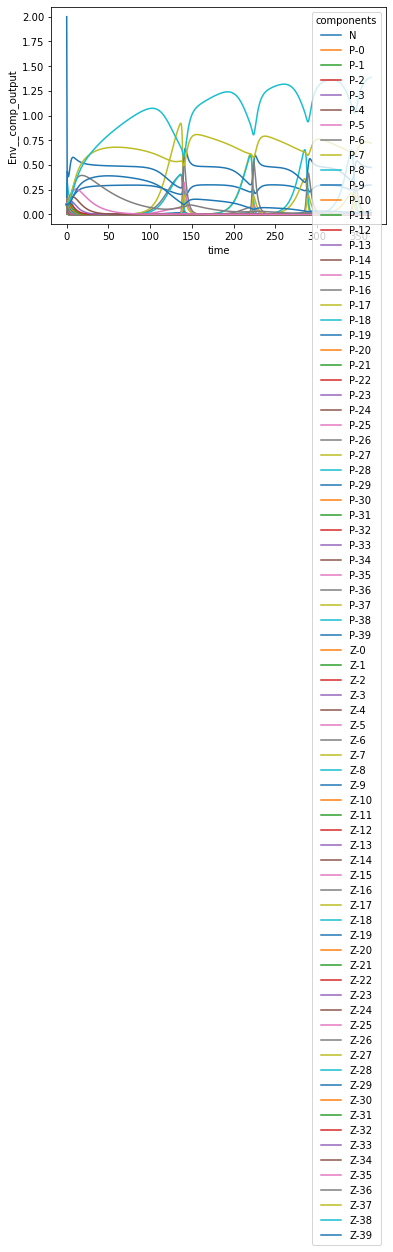

In [19]:
%%time
out_ds.Env__comp_output.plot.line(x='time')  #, ylim=0)#, ylim=(0,2.5))  # (0,2.5)
#out_ds.Env__comp_output.isel(components=slice(0,5)).sum(axis=0).plot.line(x='time')

In [13]:
out_ds.Env__forcing_output.plot.line(x='time')

AttributeError: 'Dataset' object has no attribute 'Env__forcing_output'

In [ ]:
out_ds.Env__forcing_output.sel(forcings='N0').plot(x='time')  #, time=np.arange(300,400)

In [ ]:
out_ds.Env__flux_output.plot.line(x='time')#, ylim=(0,.5))

In [ ]:
out_ds.Env__fxflux_output.plot.line(x='time')

In [48]:
with model:
    out1_ds = in_ds.xsimlab.update_vars(input_vars={'P':{'dim':1,'init':.5/1},
                                                   'Grazing':{'Imax':.5,
                                                   'halfsat':1.5,
                                                   'R_label':'P',
                                                   'C_label':'Z'}}).xsimlab.run()
    out2_ds = in_ds.xsimlab.update_vars(input_vars={'P':{'dim':2,'init':.5/2},
                                                   'Grazing':{'Imax':.5,
                                                   'halfsat':1.5/2,
                                                   'R_label':'P',
                                                   'C_label':'Z'}}).xsimlab.run()
    out5_ds = in_ds.xsimlab.update_vars(input_vars={'P':{'dim':5,'init':.5/5},
                                                   'Grazing':{'Imax':.5,
                                                   'halfsat':1.5/5,
                                                   'R_label':'P',
                                                   'C_label':'Z'}}).xsimlab.run()

Initializing Gekko Context
Initializing Model Time
dimensions of component N are initialized at 1
Initializing component  N ['N']
dimensions of component P are initialized at 1
Initializing component  P ['P']
dimensions of component Z are initialized at 1
Initializing component  Z ['Z']
ForcingBase is initialized: Flow
forcing flux Outflux is initialized at ['N' 'P' 'Z']
Initializing forcing flux Outflux for components ['N' 'P' 'Z']
flux P_Growth is initialized for N --> P
setup_dims (1, 1) P mu
[[0.7]]
setup_dims (1, 1) P halfsat_Growth
[[0.6]]
Initializing flux: P_Growth-N2P
forcing flux QuadMortality is initialized at ['Z']
Initializing forcing flux QuadMortality for components ['Z']
ForcingBase is initialized: N0
forcing flux LinMortality is initialized at ['P']
Initializing forcing flux LinMortality for components ['P']
forcing flux N0_influx is initialized at ['N']
Initializing forcing flux N0_influx for components ['N']
flux Grazing is initialized for P --> Z
setup_dims (1, 1) G

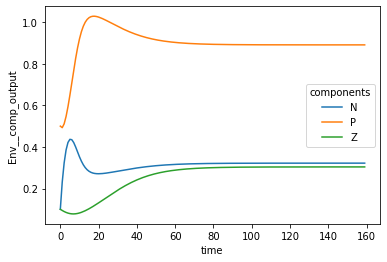

In [49]:
out1_ds.Env__comp_output.plot.line(x='time')

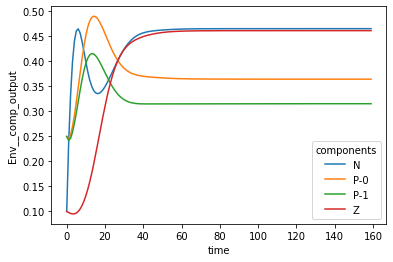

In [50]:
out2_ds.Env__comp_output.plot.line(x='time')

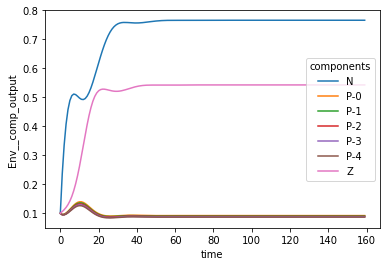

In [51]:
out5_ds.Env__comp_output.plot.line(x='time')